In [1]:
"""Data inspection."""

'Data inspection.'

In [1]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
from scipy import signal

import warnings
warnings.filterwarnings("ignore")

HOME_DIR = '/home/nina/code/sommet'
DATA_DIR = os.path.join(HOME_DIR, '2018-05-31_15-43-39')

In [2]:
HEADER_SIZE = 16 * 1024  # Header size in neuralynx formats

N_ELECTRODES = 32
SELECTED_ELECTRODES = [1, 2]

SF = 32000  # sampling rate s^-1
NYQ = SF / 2

LOWCUT = 600  # Hz
HIGHCUT = 7000  # Hz
DELTA = 100  # Hz

CHEBY_ORDER = 6
CHEBY_RIPPLE = 0.01  # DB

CHEBY_LOWCUT_HZ = LOWCUT - 4 * DELTA # 200 Hz
CHEBY_LOWCUT = CHEBY_LOWCUT_HZ / NYQ  # 0.0125 NYQ units
CHEBY_HIGHCUT_HZ = HIGHCUT + 4 * DELTA  # 7400 Hz
CHEBY_HIGHCUT = CHEBY_HIGHCUT_HZ / NYQ  # 0.4625 NYQ units 

print('Cheby filter cutoff frequencies: [{:.4f}, {:.4f}] = [{:.0f}Hz, {:.0f}Hz]'.format(
    CHEBY_LOWCUT, CHEBY_HIGHCUT, CHEBY_LOWCUT_HZ, CHEBY_HIGHCUT_HZ))

FIR_ORDER = 50  # Needs to be even, so that FIR length is odd, and FIR is type I

FIR_LOWCUT_HZ = LOWCUT - DELTA  # 500 Hz
FIR_LOWCUT = FIR_LOWCUT_HZ / NYQ  # 0.03125 NYQ units
FIR_HIGHCUT_HZ = HIGHCUT + DELTA  # 7100 Hz
FIR_HIGHCUT = FIR_HIGHCUT_HZ / NYQ  # 0.44375 NYQ units

print('FIR filter cutoff frequencies: [{:.4f}, {:.4f}] = [{:.0f}Hz, {:.0f}Hz]'.format(
    FIR_LOWCUT, FIR_HIGHCUT, FIR_LOWCUT_HZ, FIR_HIGHCUT_HZ))

EXTREME_AMPLITUDE_COEF = 0.9

MIN_FLAT = 5
PAD_FLAT = 100

SPIKE_THRESHOLD_STD = 3.1 # spike threshold in standard deviations

Cheby filter cutoff frequencies: [0.0125, 0.4625] = [200Hz, 7400Hz]
FIR filter cutoff frequencies: [0.0312, 0.4437] = [500Hz, 7100Hz]


In [3]:
def load_ncs(data_file, electrode_id=1):
    """
    Read Neuralynx NCS data.
    https://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    
    Note: Electrodes are numbered 1-32 in filenames, but 0-31 in NCS.
    """
    # QUESTION: What is the deal with the Channel Number and 50863 bad elements after CSC1?
    with open(data_file, 'rb') as fid:
        fid.seek(HEADER_SIZE)

        ncs_data_format = np.dtype([
            ('TimeStamp', np.uint64),
            ('ChannelNumber', np.uint32),
            ('SampleFreq', np.uint32),
            ('NumValidSamples', np.uint32),
            ('Samples', np.int16, 512)])
        raw = np.fromfile(fid, dtype=ncs_data_format)
        
    assert np.all(raw['SampleFreq']==SF)
    if not np.all(raw['ChannelNumber']==electrode_id-1):
        print(
            '! - Warning: There are %d elements whose ChannelNumber'
            ' does not correspond to the electrode ID.' % sum(raw['ChannelNumber']!=electrode_id-1))
    
    return raw        

In [4]:
def load_samples(data_dir=DATA_DIR, n_electrodes=N_ELECTRODES):
    """
    Load NCS from all electrodes, extract samples, concatenate in an array of dim:
    n_samples x n_electrodes
    
    Note: Electrodes are numbered 1-32 in filenames, but 0-31 in NCS.
    """
    # QUESTION: Why is there nothing in the _0001.ncs files? What are they here for?
    all_samples = []
    for i in range(n_electrodes):
        filename = 'CSC{}.ncs'.format(i+1)
        filepath = os.path.join(data_dir, filename)
        print('Loading %s...' % filepath)
        raw = load_ncs(filepath)
        samples = raw['Samples'].ravel()
        all_samples.append(samples)
        
    all_samples = np.array(all_samples)
    assert all_samples.shape[0] == n_electrodes
    return all_samples        

In [5]:
samples = load_samples()
print('Size of samples data: (%d, %d)' % samples.shape)

Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC1.ncs...
Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC2.ncs...
! - Warning: There are 50863 elements whose ChannelNumber does not correspond to the electrode ID.
Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC3.ncs...
! - Warning: There are 50863 elements whose ChannelNumber does not correspond to the electrode ID.
Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC4.ncs...
! - Warning: There are 50863 elements whose ChannelNumber does not correspond to the electrode ID.
Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC5.ncs...
! - Warning: There are 50863 elements whose ChannelNumber does not correspond to the electrode ID.
Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC6.ncs...
! - Warning: There are 50863 elements whose ChannelNumber does not correspond to the electrode ID.
Loading /home/nina/code/sommet/2018-05-31_15-43-39/CSC7.ncs...
! - Warning: There are 50863 elements whose ChannelNumber does n

In [6]:
def normalize(samples, axis=None):
    nanmean = np.nanmean(samples, axis=axis)
    nanstd = np.nanstd(samples, axis=axis)
    normalized_samples = (samples - nanmean) / nanstd
    return normalized_samples

In [7]:
def plot_samples(samples, n_msecs, title='', electrodes_nums=None, sf=SF):
    """
    Plot first ms of the samples.
    """
    if electrodes_nums is None:
        electrodes_nums = range(1, N_ELECTRODES+1)
    if isinstance(electrodes_nums, int):
        electrodes_nums = [electrodes_nums]
        
    electrodes_ids = [num - 1 for num in electrodes_nums]
        
    _, n_samples = samples.shape
    n_secs = 0.001 * n_msecs
    
    last_time_stamp_id = int(np.floor(n_secs*SF))-1
    
    # Total duration of recording in seconds
    dur_sec =  n_samples / sf
    
    time_sec = np.linspace(0, dur_sec, n_samples)
    time_msec = 1000 * time_sec
        
    fig, ax = plt.subplots(figsize=(20, 8))
    
    for i in electrodes_ids:
        ax.plot(
            time_msec[0:last_time_stamp_id+1], 
            samples[i, 0:last_time_stamp_id+1],
            label='Electrode: %d' % (i+1))
        
    ax.set_title(
        label=title,
        fontsize=23)
    ax.set_xlim(0, time_msec[last_time_stamp_id])
    ax.set_xlabel('time [ms]', fontsize=20)
    ax.set_ylabel('amplitude [uV]', fontsize=20)
    
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
    ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1), shadow=True, ncol=1)
    
    plt.show()

In [8]:
def plot_samples_several_windows(samples, list_n_msecs=None, title='', electrodes_nums=None, sf=SF):
    if list_n_msecs is None:
        _, n_samples = samples.shape
        dur_sec =  n_samples / sf
        n_msecs = 1000 * dur_sec
        plot_samples(
                samples, n_msecs=n_msecs, title=title, electrodes_nums=electrodes_nums, sf=sf)
        
    else:
        for n_msecs in list_n_msecs:
            plot_samples(
                samples, n_msecs=n_msecs, title=title, electrodes_nums=electrodes_nums, sf=sf)

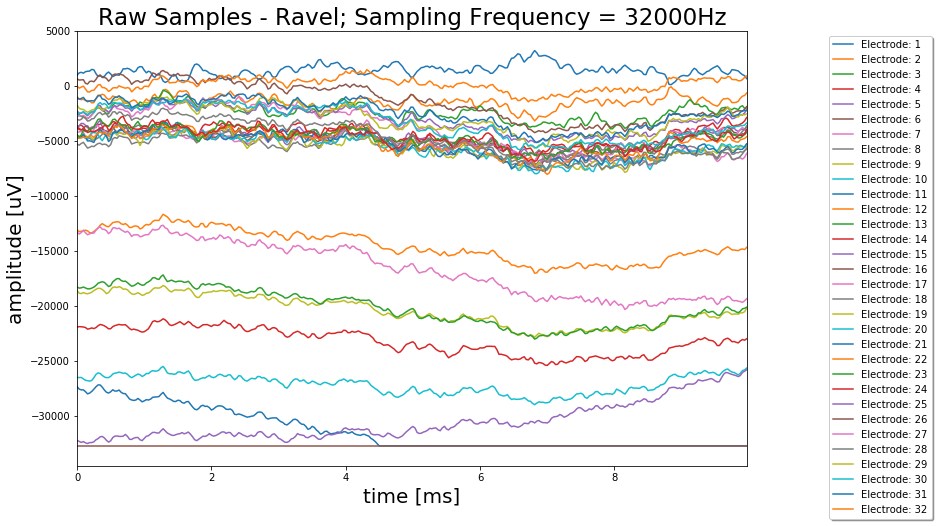

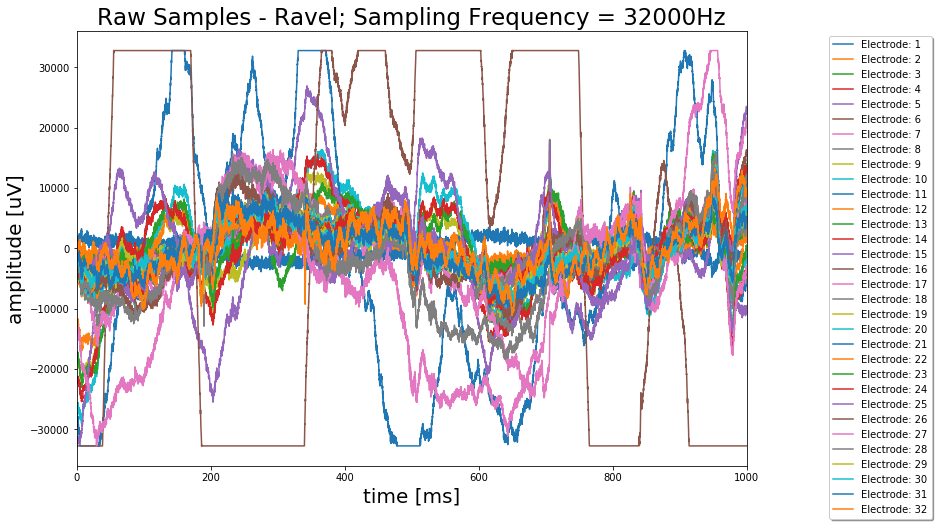

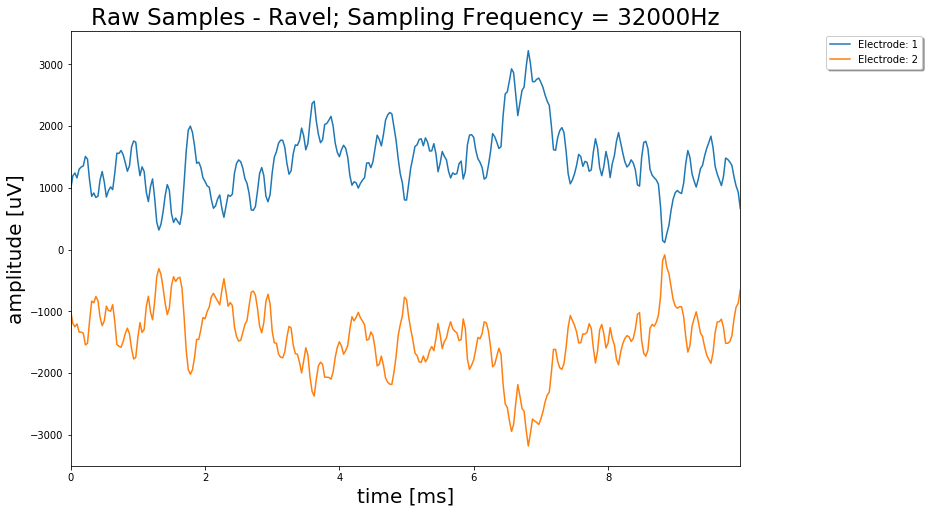

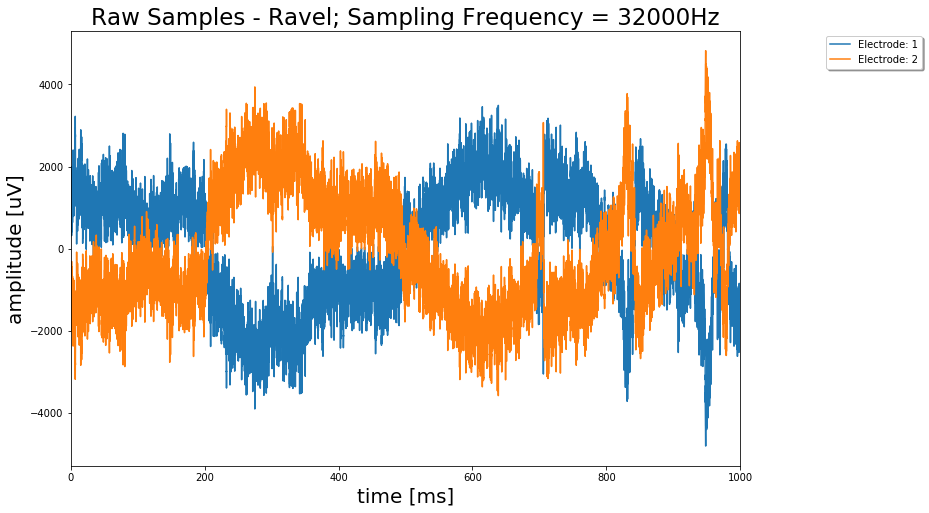

In [33]:
title = 'Raw Samples - Ravel; Sampling Frequency = {}Hz'.format(SF)

# All electrodes
plot_samples_several_windows(
    samples, list_n_msecs=[10, 1000], title=title)

# Selected electrodes
plot_samples_several_windows(
    samples, list_n_msecs=[10, 1000], title=title, electrodes_nums=SELECTED_ELECTRODES)

In [17]:
def plot_frequency_response_analog(b, a):
    """Analog: use freqs."""
    w, h = signal.freqs(b, a, worN=np.logspace(-1, 2, 1000))  
    
    plt.figure(figsize=(10, 8))
    
    plt.semilogx(w, 20 * np.log10(abs(h)))
    
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Amplitude response [dB]', fontsize=20)
    plt.grid()
    plt.show()

In [18]:
def plot_frequency_response_digital(b, a=1):
    """Digital: use freqz."""
    w, h = signal.freqz(b, a, worN=np.logspace(-1, 2, 1000))
    
    plt.figure(figsize=(10, 8))
    
    plt.semilogx(w, 20 * np.log10(abs(h)))
    
    plt.xlabel('Frequency [rad/sample]', fontsize=20)  # Here the digital thing?
    plt.ylabel('Amplitude response [dB]', fontsize=20)
    plt.grid()
    plt.show()

In [9]:
def filter_cheby(samples, order=CHEBY_ORDER, ripple=CHEBY_RIPPLE, lowcut=CHEBY_LOWCUT, highcut=CHEBY_HIGHCUT):
    """
    First filter applied by Eric, in matlab code from Archive.zip.
    IIR cuts low frequencies with a sharp filter.
    Note: Similar to the bandpass filter from the tutorial.
    It is actually a bandpass filter, with ripples.
    """
    cutoff_frequencies = [lowcut, highcut]

    b0, a0 = signal.cheby1(
        N=order, 
        rp=ripple,
        Wn=cutoff_frequencies, 
        btype='bandpass')
    filtered_samples = signal.filtfilt(b0, a0, samples, axis=-1)
    return filtered_samples, b0, a0

In [10]:
samples_cheby, b0, a0 = filter_cheby(samples)

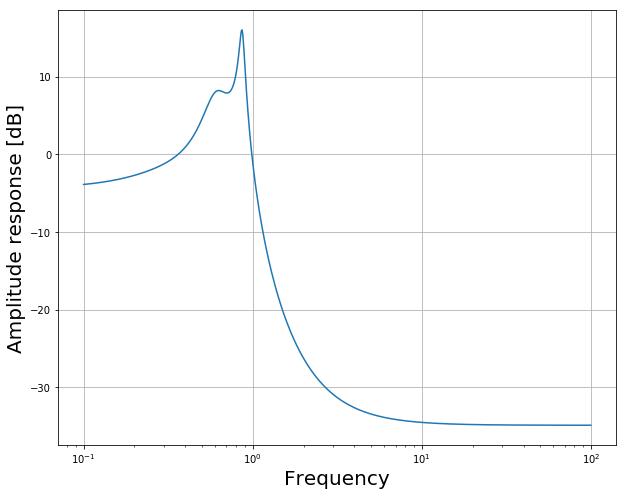

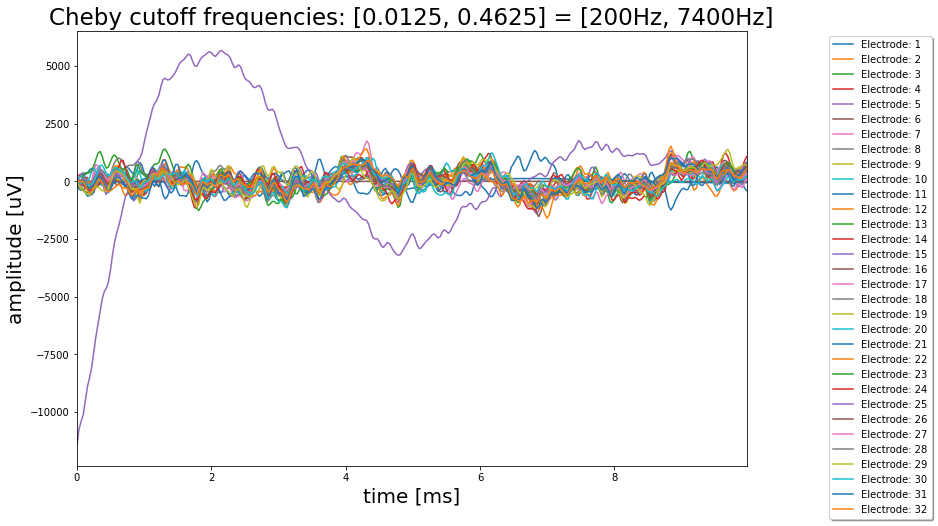

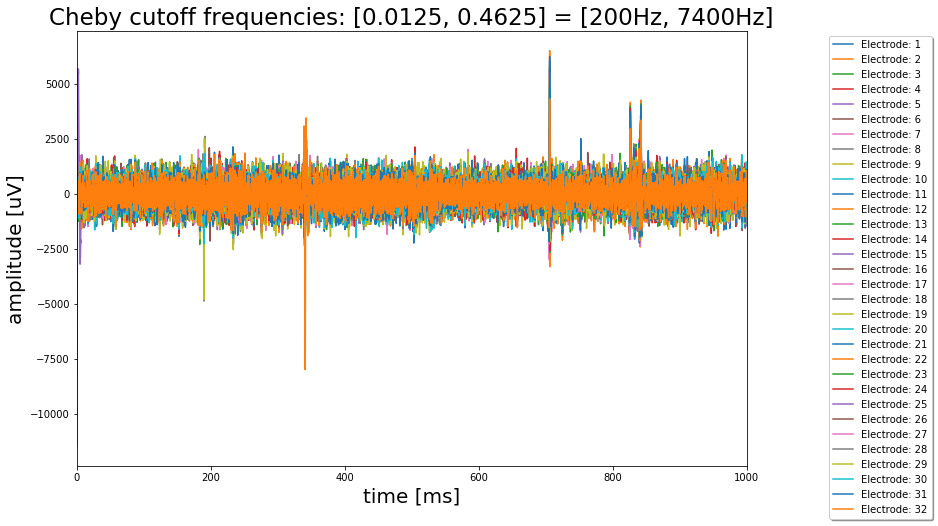

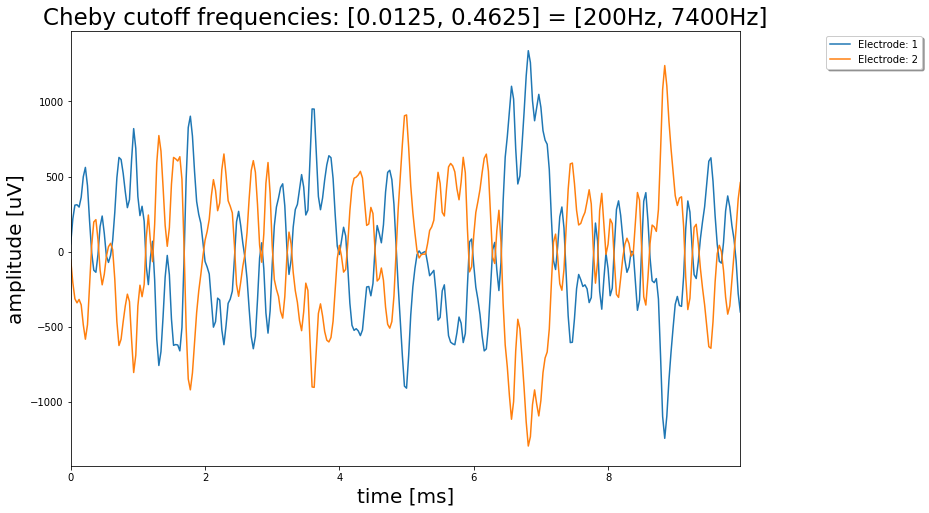

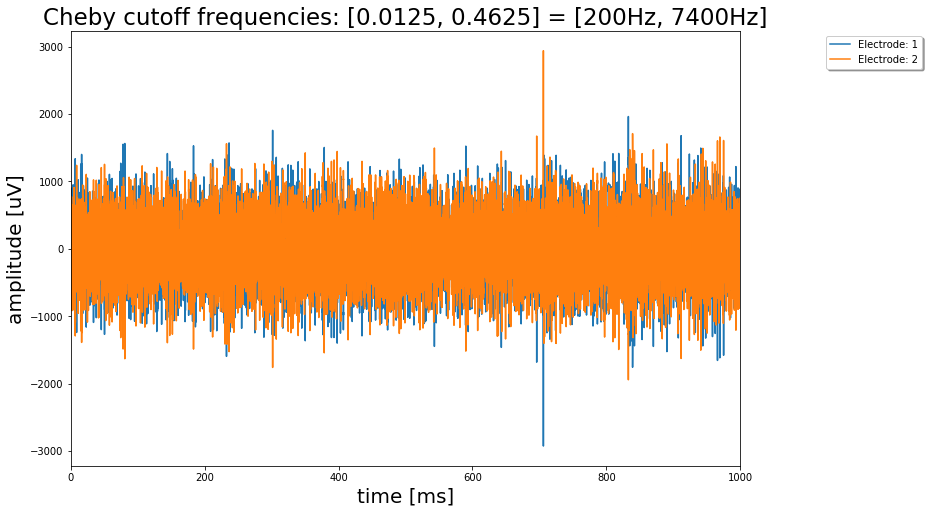

In [34]:
plot_frequency_response_analog(b0, a0)

title_cheby = 'Cheby cutoff frequencies: [{:.4f}, {:.4f}] = [{:.0f}Hz, {:.0f}Hz]'.format(
    CHEBY_LOWCUT, CHEBY_HIGHCUT, CHEBY_LOWCUT_HZ, CHEBY_HIGHCUT_HZ)

# All electrodes
plot_samples_several_windows(
    samples_cheby, list_n_msecs=[10, 1000], title=title_cheby)

# Selected electrodes
plot_samples_several_windows(
    samples_cheby, list_n_msecs=[10, 1000], title=title_cheby, electrodes_nums=SELECTED_ELECTRODES)


Test single signal

Test multiple electrodes
(3, 550)


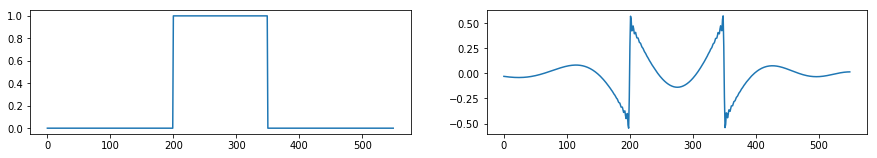

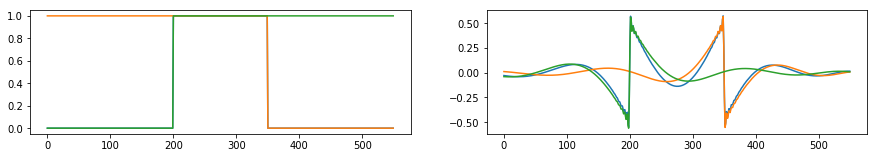

In [16]:
def test_filter_cheby():
    n = 200
    m = 150
    zeros = np.zeros(n)
    ones = np.ones(m)
    
    print('\nTest single signal')
    test_samples = np.concatenate([zeros, ones, zeros])
    times = range(len(test_samples))
    result, _, _ = filter_cheby(test_samples)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 2, 1)
    plt.plot(times, test_samples)
    plt.subplot(2, 2, 2)
    plt.plot(times, result)
    
    print('\nTest multiple electrodes')
    n_electrodes = 3
    test_samples_1 = np.concatenate([zeros, ones, zeros])
    test_samples_2 = np.concatenate([np.ones_like(zeros), ones, zeros])
    test_samples_3 = np.concatenate([zeros, ones, np.ones_like(zeros)])
    
    test_samples = np.vstack([test_samples_1, test_samples_2, test_samples_3])
    print(test_samples.shape)
    times = range(test_samples.shape[1])
    result, _, _ = filter_cheby(test_samples)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 2, 1)
    for i in range(n_electrodes):
        plt.plot(times, test_samples[i])
    plt.subplot(2, 2, 2)
    for i in range(n_electrodes):
        plt.plot(times, result[i])
test_filter_cheby()

In [11]:
def filter_firwin(samples, order=FIR_ORDER, lowcut=FIR_LOWCUT, highcut=FIR_HIGHCUT):
    """
    Second filter applied by Eric, in matlab code from Archive.zip.
    Low order Hann Filter.
    
    Rmk: Length of the filter = number of coefficients, i.e. the filter order + 1.
    Note: A bandpass filter again.
    """
    length = order + 1 
    cutoff_frequencies = [lowcut, highcut]
    
    b1 = signal.firwin(
        numtaps=length,
        cutoff=cutoff_frequencies, 
        pass_zero=False,  # Otherwise is bandstop by default!
        window='hann')
    beq = np.convolve(b1, b1) # 2 stage filter
    
    # Applying filters, with 0 phase lag
    filtered_samples = signal.filtfilt(beq, 1, samples, axis=-1)
    return filtered_samples, beq

In [12]:
samples_firwin, beq = filter_firwin(samples_cheby)

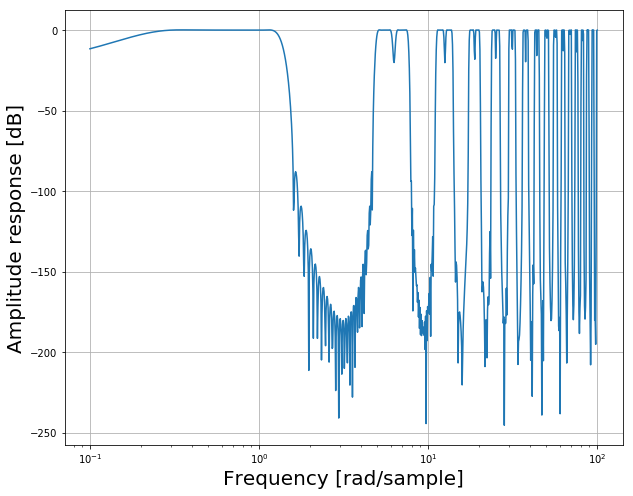

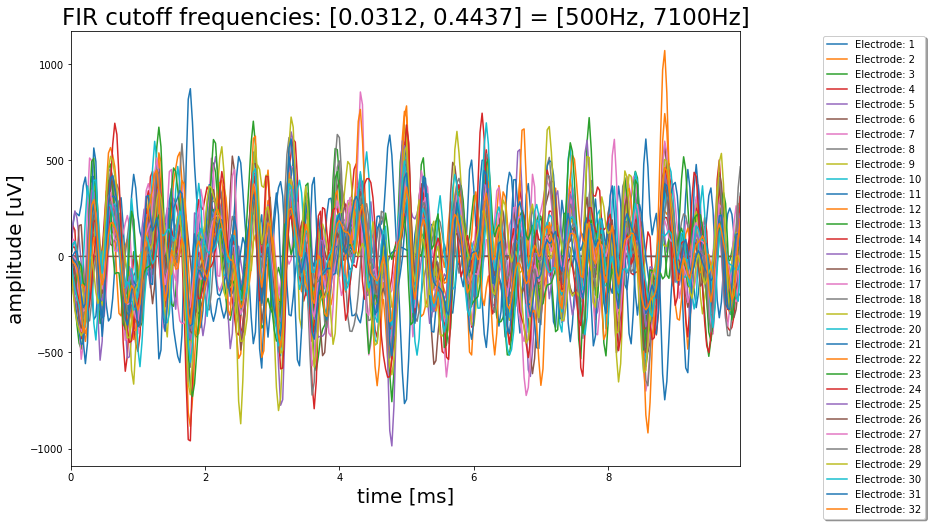

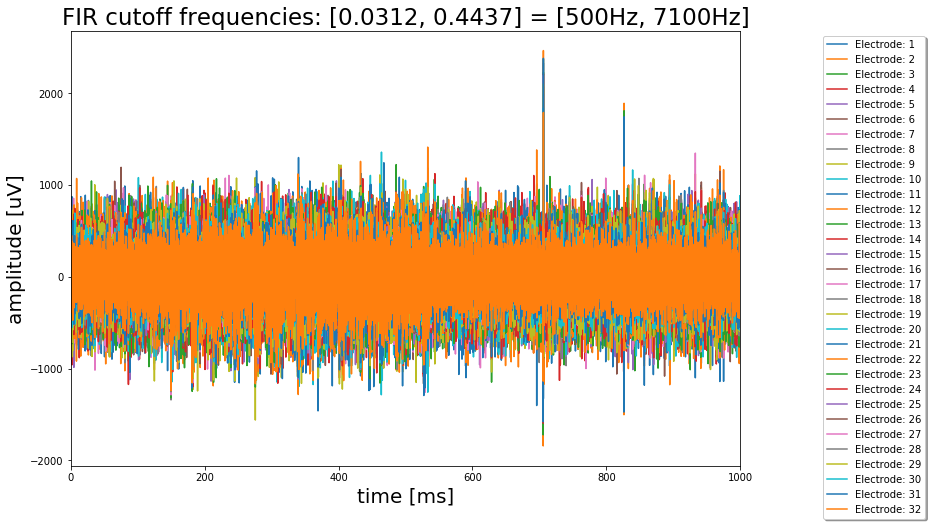

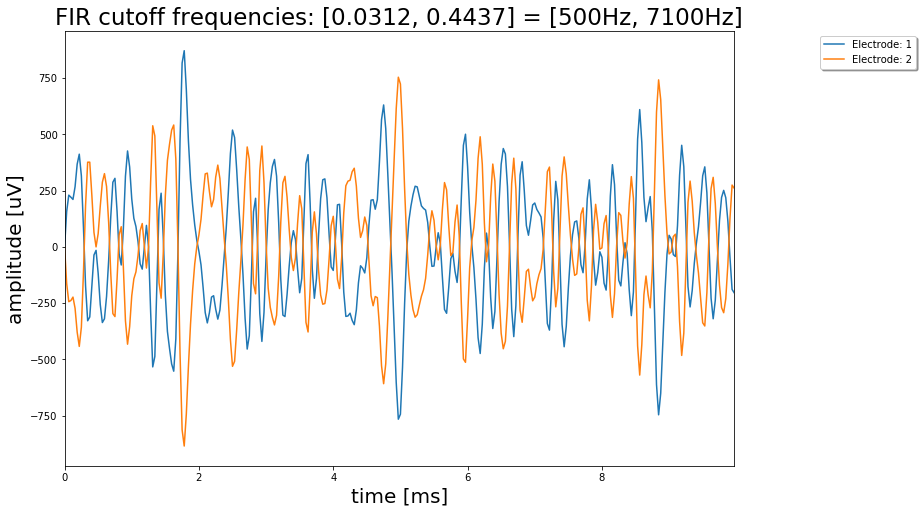

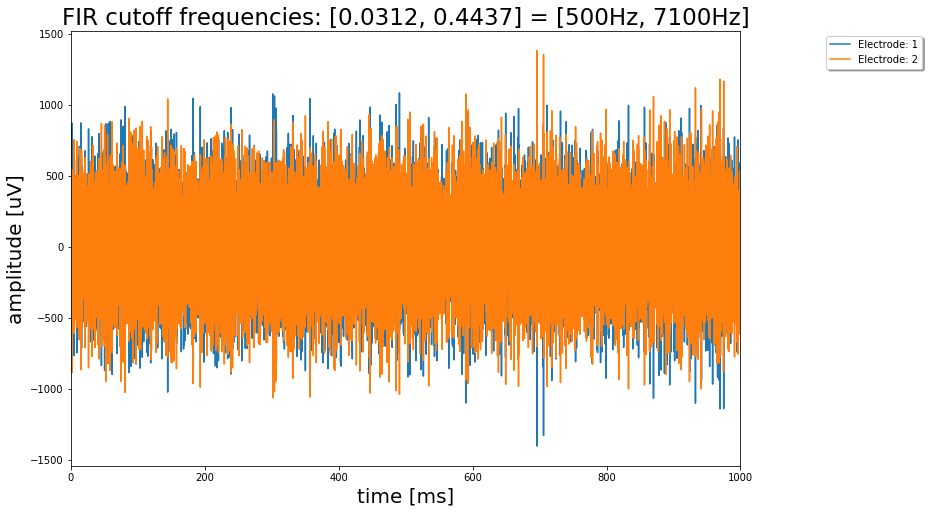

In [19]:
plot_frequency_response_digital(beq)

title_firwin = 'FIR cutoff frequencies: [{:.4f}, {:.4f}] = [{:.0f}Hz, {:.0f}Hz]'.format(
    FIR_LOWCUT, FIR_HIGHCUT, FIR_LOWCUT_HZ, FIR_HIGHCUT_HZ)

# All electrodes
plot_samples_several_windows(
    samples_firwin, list_n_msecs=[10, 1000], title=title_firwin)

# Selected electrodes
plot_samples_several_windows(
    samples_firwin, list_n_msecs=[10, 1000], title=title_firwin, electrodes_nums=SELECTED_ELECTRODES)

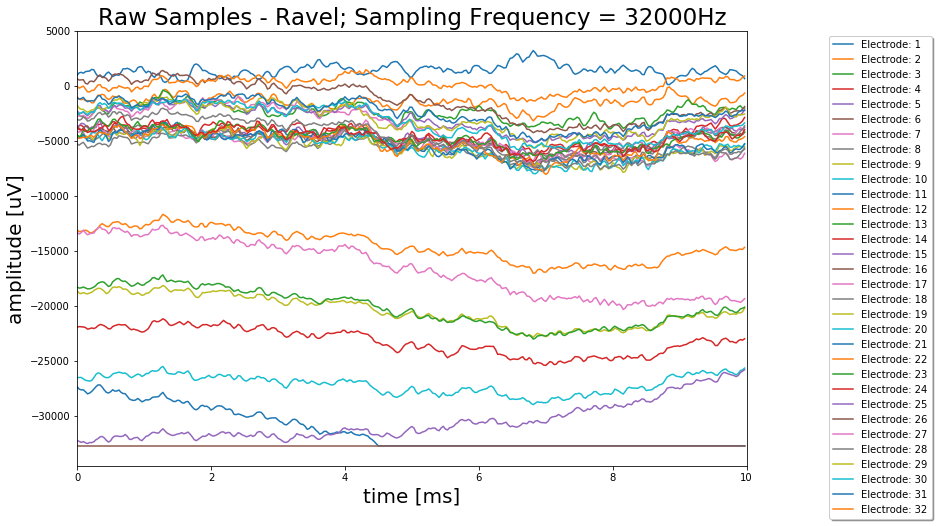

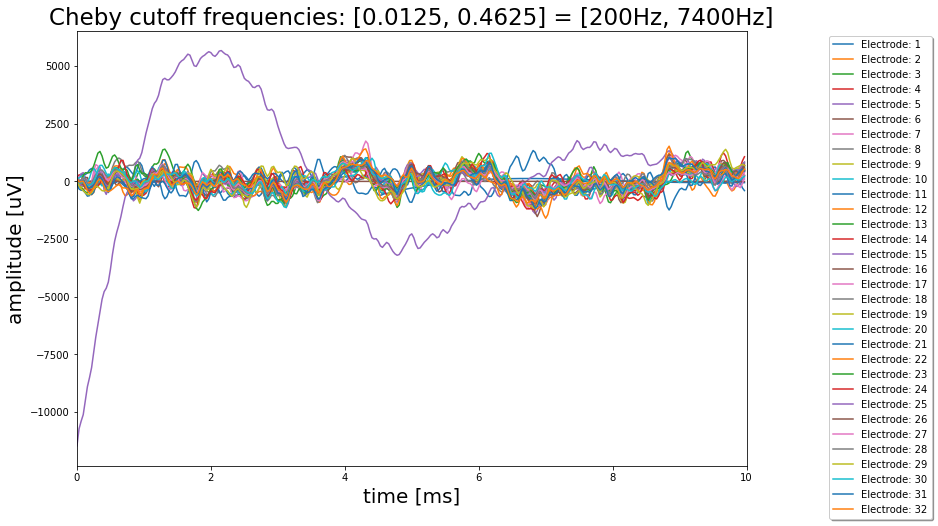

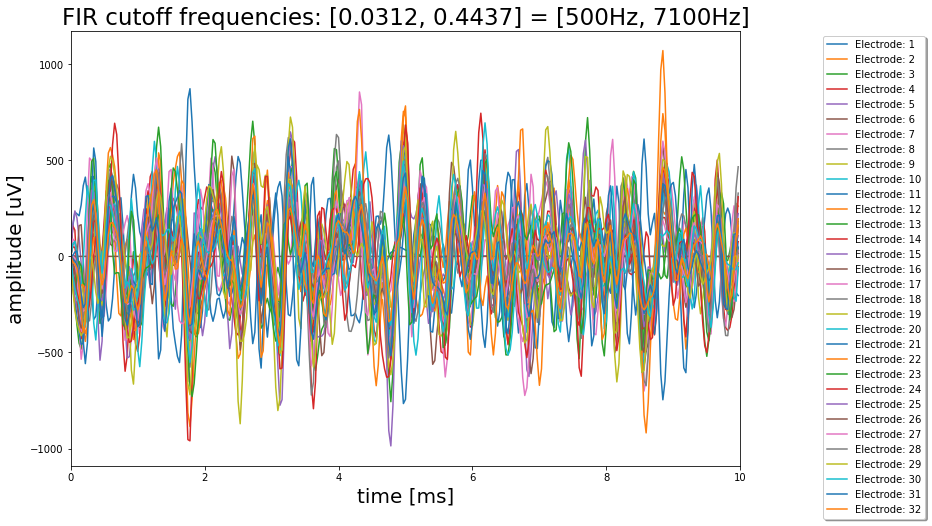

In [20]:
# Consecutive filters on same graph - Note: not same units on amplitudes!
plot_samples(samples, n_msecs=10, title=title)
plot_samples(samples_cheby, n_msecs=10, title=title_cheby)
plot_samples(samples_firwin, n_msecs=10, title=title_firwin)


Test single signal

Test multiple electrodes
(3, 550)


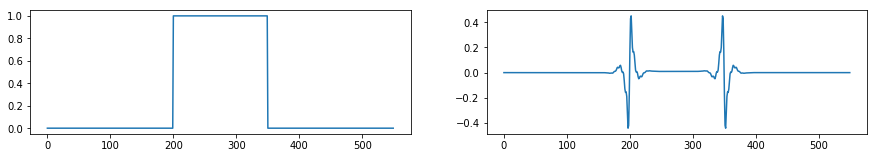

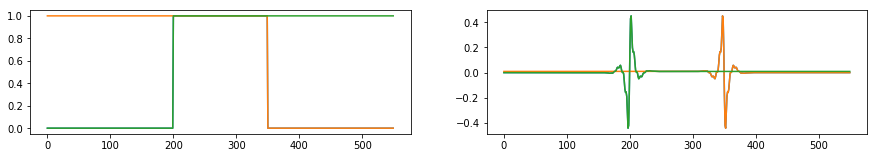

In [20]:
def test_filter_firwin():
    n = 200
    m = 150
    zeros = np.zeros(n)
    ones = np.ones(m)
    
    print('\nTest single signal')
    test_samples = np.concatenate([zeros, ones, zeros])
    times = range(len(test_samples))
    result, _= filter_firwin(test_samples)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 2, 1)
    plt.plot(times, test_samples)
    plt.subplot(2, 2, 2)
    plt.plot(times, result)
    
    print('\nTest multiple electrodes')
    n_electrodes = 3
    test_samples_1 = np.concatenate([zeros, ones, zeros])
    test_samples_2 = np.concatenate([np.ones_like(zeros), ones, zeros])
    test_samples_3 = np.concatenate([zeros, ones, np.ones_like(zeros)])
    
    test_samples = np.vstack([test_samples_1, test_samples_2, test_samples_3])
    print(test_samples.shape)
    times = range(test_samples.shape[1])
    result, _ = filter_firwin(test_samples)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 2, 1)
    for i in range(n_electrodes):
        plt.plot(times, test_samples[i])
    plt.subplot(2, 2, 2)
    for i in range(n_electrodes):
        plt.plot(times, result[i])
test_filter_firwin()

In [13]:
def remove_extreme_amplitudes(samples, coef=EXTREME_AMPLITUDE_COEF, axis=-1):
    """
    From Eric's code in Archive.
    Removing the data above 90% of the extremum values.
    
    Note: dtype must be float to have NaNs. Int will fill with an arbitrarily large number.
    - axis=None: compute min and max amplitudes accross all electrodes.
    - axis=0: compute min and max per electrode.
    """
    # TODO(nina): Consider in place version of this function, for memory optimization.
    # TODO(nina): Vectorize wrt electrodes.
    # QUESTION: Compute min and max per electrode or across all electrodes?
    samples = np.atleast_2d(samples)
    n_electrodes, n_samples = samples.shape
   
    min_amplitude = np.nanmin(samples, axis=axis)
    max_amplitude = np.nanmax(samples, axis=axis)
    
    if axis==-1:
        min_amplitude = np.expand_dims(min_amplitude, axis=1)
        max_amplitude = np.expand_dims(max_amplitude, axis=1)
        interval = np.concatenate([min_amplitude, max_amplitude], axis=1)
    
    elif axis==None:
        min_amplitude = np.atleast_2d(min_amplitude)
        max_amplitude = np.atleast_2d(max_amplitude)
        interval = np.concatenate([min_amplitude, max_amplitude], axis=1)
        interval = np.concatenate([interval] * n_electrodes, axis=0)
    else:
        raise ValueError()

    valid_interval = interval * coef
    
    low_bool = np.zeros_like(samples)
    high_bool = np.zeros_like(samples)
    for i in range(n_electrodes):
        low_bool[i] = samples[i] <= valid_interval[i, 0]
        high_bool[i] = samples[i] >= valid_interval[i, 1]
       
    bad_amplitudes_mask = np.logical_or(low_bool, high_bool)
    n_bad_samples = np.sum(bad_amplitudes_mask, axis=-1)
    
    for i in range(n_electrodes):
        print(
            'Electrode: {}. Found {}/{} points with extreme amplitude. '
            'Fill with NaN.'.format(i+1, n_bad_samples[i], n_samples))

    filtered_samples = np.copy(samples)
    filtered_samples[bad_amplitudes_mask] = np.nan
    return filtered_samples

In [14]:
samples_no_extreme = remove_extreme_amplitudes(samples_firwin)

Electrode: 1. Found 7/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 2. Found 7/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 3. Found 8/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 4. Found 6/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 5. Found 6/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 6. Found 8/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 7. Found 8/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 8. Found 5/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 9. Found 7/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 10. Found 5/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 11. Found 4/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 12. Found 9/26041856 points with extreme amplitude. Fill with NaN.
Electrode: 13. Found 6/26041856 points with extreme amplitude. Fill with 

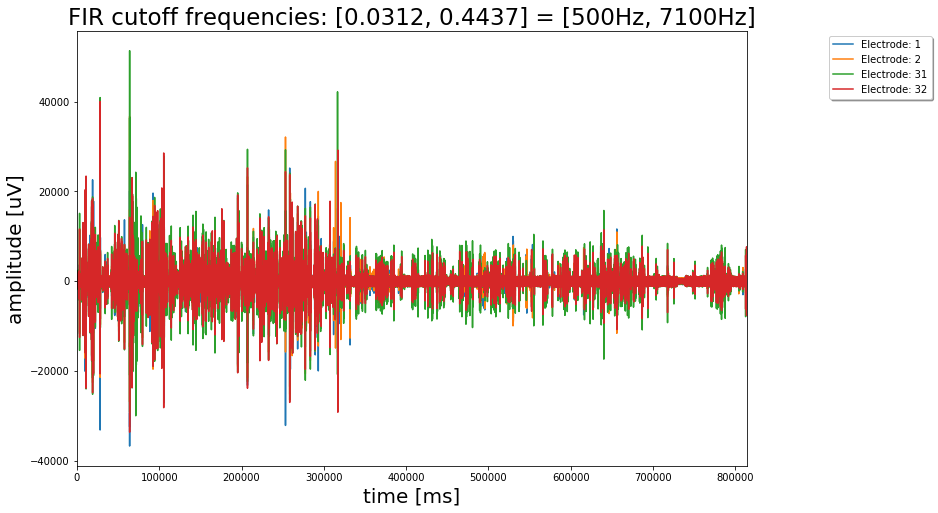

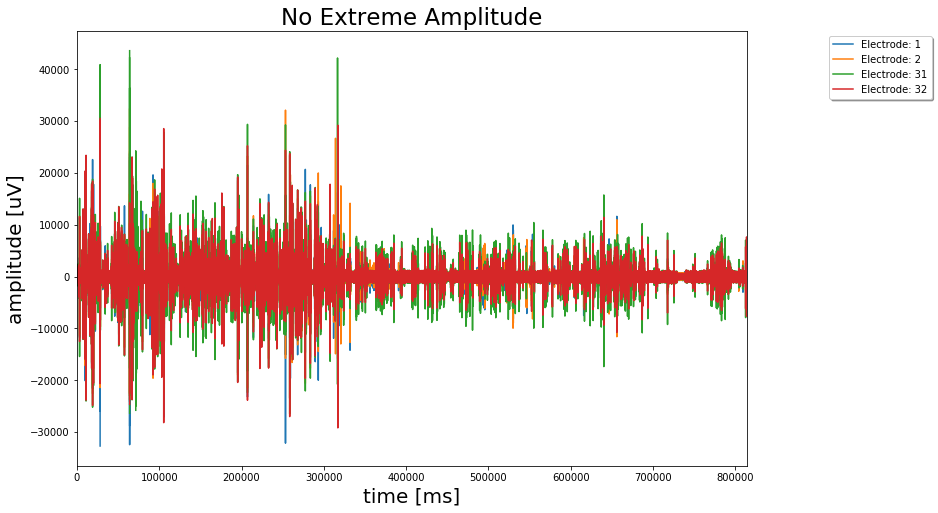

In [20]:
# Plot over the full time window here
plot_samples_several_windows(samples_firwin, title=title_firwin, electrodes_nums=[1, 2, 31, 32])
plot_samples_several_windows(samples_no_extreme, title='No Extreme Amplitude', electrodes_nums=[1, 2, 31, 32])

In [32]:
def test_remove_extreme_amplitudes():
    n_electrodes = 3
    print('\nTest with one electrode')
    test_samples = np.array([-0.1, 0.1, -0.2, 10, -10, 0.2])
    result = remove_extreme_amplitudes(test_samples)
    # expected = np.array([-0.1, 0.1, -0.2, np.nan, np.nan, 0.2])
    print(test_samples)
    print(result)
    
    print('\nTest with one electrode')
    test_samples = np.array([-0.1, np.nan, -0.2, 10, -10, 0.2])
    result = remove_extreme_amplitudes(test_samples)
    # expected = np.array([-0.1, np.nan, -0.2, np.nan, np.nan, 0.2])
    print(test_samples)
    print(result)

    
    print('\nTest with %d electrode - axis=None' % n_electrodes)
    test_samples = np.array([
        [-0.1, np.nan, -0.2, 10, -10, 0.2],
        [-1, np.nan, -2, 100, -100, 3],
        [-0.1, -1000, -0.2, 10, -10, 0.2]])
    result = remove_extreme_amplitudes(test_samples, axis=None)
    # expected = np.array([-0.1, np.nan, -0.2, np.nan, np.nan, 0.2])
    print(test_samples)
    print(result)
        
    print('\nTest with %d electrode - axis=-1' % n_electrodes)
    test_samples = np.array([
        [-0.1, np.nan, -0.2, 10, -10, 0.2],
        [-1, np.nan, -2, 100, -100, 3],
        [-0.1, -1000, -0.2, 10, -10, 0.2]])
    result = remove_extreme_amplitudes(test_samples)
    # expected = np.array([-0.1, np.nan, -0.2, np.nan, np.nan, 0.2])
    print(test_samples)
    print(result)
    
test_remove_extreme_amplitudes()


Test with one electrode
Electrode: 1. Found 2/6 points with extreme amplitude. Fill with NaN.
[ -0.1   0.1  -0.2  10.  -10.    0.2]
[[-0.1  0.1 -0.2  nan  nan  0.2]]

Test with one electrode
Electrode: 1. Found 2/6 points with extreme amplitude. Fill with NaN.
[ -0.1   nan  -0.2  10.  -10.    0.2]
[[-0.1  nan -0.2  nan  nan  0.2]]

Test with 3 electrode - axis=None
Electrode: 1. Found 0/6 points with extreme amplitude. Fill with NaN.
Electrode: 2. Found 1/6 points with extreme amplitude. Fill with NaN.
Electrode: 3. Found 1/6 points with extreme amplitude. Fill with NaN.
[[-1.e-01     nan -2.e-01  1.e+01 -1.e+01  2.e-01]
 [-1.e+00     nan -2.e+00  1.e+02 -1.e+02  3.e+00]
 [-1.e-01 -1.e+03 -2.e-01  1.e+01 -1.e+01  2.e-01]]
[[  -0.1    nan   -0.2   10.   -10.     0.2]
 [  -1.     nan   -2.     nan -100.     3. ]
 [  -0.1    nan   -0.2   10.   -10.     0.2]]

Test with 3 electrode - axis=-1
Electrode: 1. Found 2/6 points with extreme amplitude. Fill with NaN.
Electrode: 2. Found 2/6 poin

In [44]:
def contiguous_regions(condition):
    """
    Finds contiguous True regions of the boolean array "condition". 
    
    Returns a 2D array where:
    - the first column is the start index of the region,
    - the second column is the end index.
    """
    condition = np.atleast_2d(condition)
    n_electrodes, _ = condition.shape
    # Changes in "condition"
    d = np.diff(condition, axis=-1)
    
    indices = {}
    for i in range(n_electrodes):
        idx, = d[i].nonzero() 
        condition_i = condition[i]

        # We need to start things after the change in "condition". Therefore, 
        # we'll shift the index by 1 to the right.
        idx += 1

        if condition_i[0]:
            # If the start of condition is True prepend a 0
            idx = np.r_[0, idx]

        if condition_i[-1]:
            # If the end of condition is True, append the length of the array
            idx = np.r_[idx, condition_i.size] # Edit

        # Reshape the result into two columns
        idx.shape = (-1,2)
        indices[i] = idx
    
    return indices

In [45]:
def remove_flat(raw_samples, samples, min_flat=MIN_FLAT, pad_flat=PAD_FLAT):
    """
    Remove data in samples around flat regions of the **raw** samples.
    Minimum of min_flat consecutives 0 slopes.
    Pad with pad_flat before and after the consecutives 0 slopes.
    
    Note: dtype must be float to have NaNs. Int will fill with an arbitrarily large number.
    
    Then rescale around 0 mean.
    """
    # TODO(nina): Is this information in ValidSample field?
    # TODO(nina): Consider doing this function in place for memory optimization.
    samples = np.atleast_2d(samples)
    n_electrodes, n_samples = samples.shape
    filtered_samples = np.copy(samples)  
    
    slopes = np.diff(raw_samples, axis=-1)
    slope0_mask = slopes == 0
    
    contiguous_indices = contiguous_regions(slope0_mask)
    
    for i in range(n_electrodes):
        contiguous_ids = contiguous_indices[i]
        lengths = np.array([end - start + 1 for start, end in contiguous_ids])
        
        for length, ids in zip(lengths, contiguous_ids):
            if length >= min_flat:
                start_remove = np.max([0, ids[0] - pad_flat])
                end_remove = np.min([n_samples, ids[1] + pad_flat + 1])
                filtered_samples[i, start_remove:end_remove] = np.nan

    return filtered_samples

def remove_flat_and_normalize(raw_samples, samples, min_flat=MIN_FLAT, pad_flat=PAD_FLAT):
    filtered_samples = remove_flat(raw_samples, samples, min_flat=min_flat, pad_flat=pad_flat)
    filtered_samples = normalize(filtered_samples)
    return filtered_samples

In [39]:
samples_no_flat = remove_flat_and_normalize(samples, samples_no_extreme)

Electrode: 0
[     325      326      473 ... 26041761 26041848 26041849]
Electrode: 1
[       3        4      120 ... 26041654 26041815 26041816]
Electrode: 2
[     266      267      803 ... 26041641 26041831 26041832]
Electrode: 3
[     430      431      484 ... 26041596 26041841 26041842]
Electrode: 4
[    1092     1093     1343 ... 26040947 26041613 26041614]
Electrode: 5
[      60       61      490 ... 26039987 26040755 26040756]
Electrode: 6
[      32       33      105 ... 26040396 26040806 26040807]
Electrode: 7
[     135      136      232 ... 26040657 26041389 26041390]
Electrode: 8
[     576      577     1015 ... 26041680 26041815 26041816]
Electrode: 9
[     395      396      734 ... 26040761 26041199 26041200]
Electrode: 10
[     143     1055     1058 ... 26041619 26041653 26041654]
Electrode: 11
[     336      337      400 ... 26041159 26041532 26041533]
Electrode: 12
[     599      600     1072 ... 26041680 26041706 26041707]
Electrode: 13
[     434      435      767 ... 26

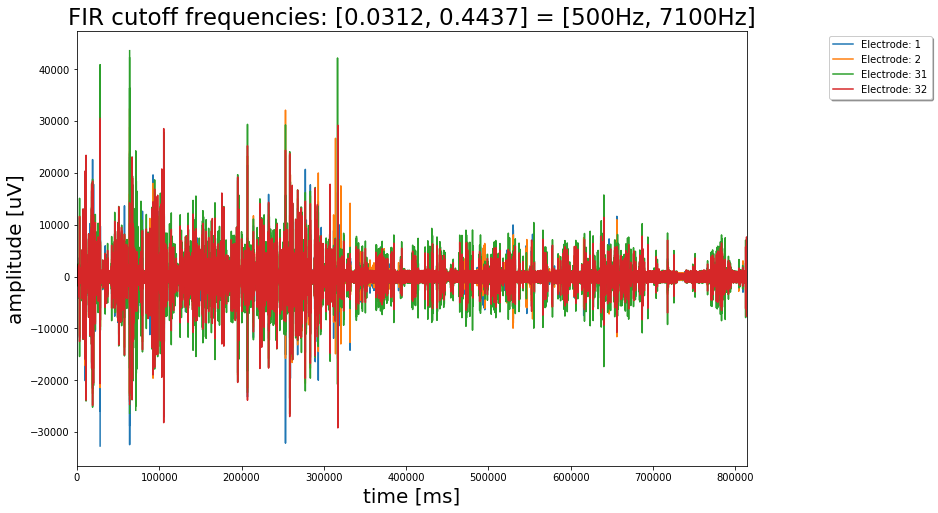

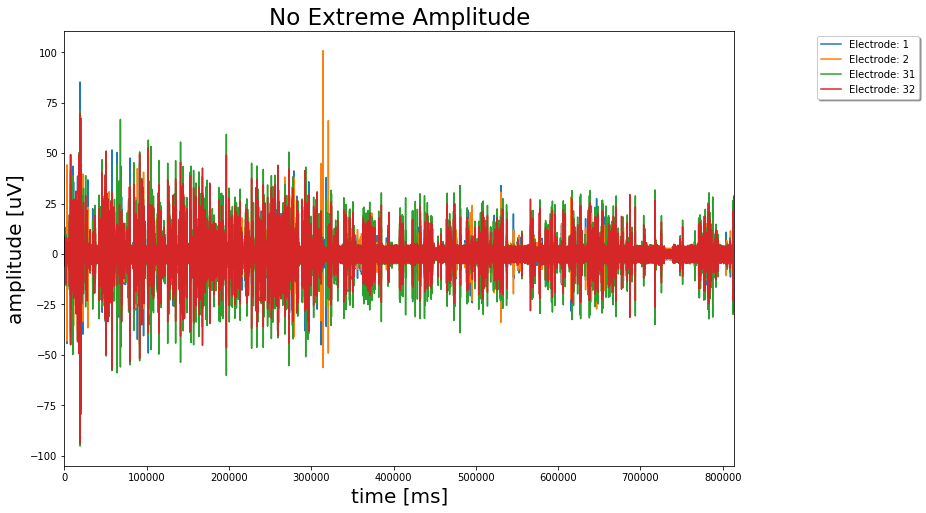

In [40]:
# QUESTION: Why removing flat elements here, using the original samples? Why not removing them directly?

# Plot over the full time window here
plot_samples_several_windows(samples_no_extreme, title='No Extreme Amplitude', electrodes_nums=[1, 2, 31, 32])
plot_samples_several_windows(samples_no_flat, title='No Flat', electrodes_nums=[1, 2, 31, 32])

In [46]:
def test_remove_flat():
    print('\ntest with not enough consecutives flatness -  no pad')
    test_samples = np.array([1, 2, 2, 2, 2, 2, 2, 2, 5, 6, 7, 7, 7, 8, 8, 9], dtype=np.float64)
    result = remove_flat(test_samples, test_samples, min_flat=9, pad_flat=0)
    print(result)
    
    print('\ntest with enough consecutives flatness - no pad')
    test_samples = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 7, 7, 7, 8, 8, 9], dtype=np.float64)
    result = remove_flat(test_samples, test_samples, pad_flat=0)
    print(result)
    
    print('\ntest with enough consecutives flatness - pad 1')
    test_samples = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 7, 7, 7, 8, 8, 9], dtype=np.float64)
    result = remove_flat(test_samples, test_samples, pad_flat=1)
    print(result)
    
    print('\ntest with enough consecutives flatness - pad 3')
    test_samples = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 7, 7, 7, 8, 8, 9], dtype=np.float64)
    result = remove_flat(test_samples, test_samples, pad_flat=3)
    print(result)
    
    print('\ntest with enough consecutives flatness - pad 100')
    test_samples = np.array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 7, 7, 7, 8, 8, 9], dtype=np.float64)
    result = remove_flat(test_samples, test_samples, pad_flat=100)
    print(result)
test_remove_flat()


test with not enough consecutives flatness -  no pad
[[1. 2. 2. 2. 2. 2. 2. 2. 5. 6. 7. 7. 7. 8. 8. 9.]]

test with enough consecutives flatness - no pad
[[ 1. nan nan nan nan nan nan nan nan nan  5.  6.  7.  7.  7.  8.  8.  9.]]

test with enough consecutives flatness - pad 1
[[nan nan nan nan nan nan nan nan nan nan nan  6.  7.  7.  7.  8.  8.  9.]]

test with enough consecutives flatness - pad 3
[[nan nan nan nan nan nan nan nan nan nan nan nan nan  7.  7.  8.  8.  9.]]

test with enough consecutives flatness - pad 100
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


In [47]:
def mad(data, axis=None):
    """Mean Absolute Deviation."""
    nanmean = np.nanmean(data, axis)
    deviations = np.abs(data - nanmean)
    mad = np.nanmean(deviations, axis)
    return mad

In [99]:
def get_minima_mask(samples):
    """
    Find minima in the samples: True if there is a minimum, False if not.
    """
    samples = np.atleast_2d(samples)
    n_electrodes, _ = samples.shape
    
    slopes = np.diff(samples, axis=-1)
    
    neg_slope_mask = slopes[:, :-1] < 0
    pos_slope_mask = slopes[:, 1:] > 0
    minima_mask = np.logical_and(neg_slope_mask, pos_slope_mask)
    
    # First and last element cannot be minima
    false = np.concatenate([[False]] * n_electrodes, axis=0)
    false = np.expand_dims(false, axis=1)
    minima_mask = np.concatenate([false, minima_mask, false], axis=1)
    
    return minima_mask


def get_peaks_mask(samples, threshold_std):
    """
    Find peaks in the samples: True if there is a peak, False if not.
    Note: the std of the data is estimated through the MAD, more robust to noise.
    """
    samples = np.atleast_2d(samples)
    n_electrodes, _ = samples.shape
    
    minima_mask = get_minima_mask(samples)
    
    std = 1.4826 * mad(samples)
    
    threshold = - threshold_std * std
    threshold_mask = samples[:, 1:-1] < threshold
    
    # First and last element cannot be peaks
    false = np.concatenate([[False]] * n_electrodes, axis=0)
    false = np.expand_dims(false, axis=1)
    threshold_mask = np.concatenate([false, threshold_mask, false], axis=1)
    
    peaks_mask = np.logical_and(minima_mask, threshold_mask)
    return peaks_mask
    

def get_peaks(samples, threshold_std, channel_id=0):
    """ 
    Finds peaks in our data
    Code based from Abdul's code &
    https://www.frontiersin.org/articles/10.3389/fnins.2016.00537/full

    Peaks are defined as minima that are threshold*std away from 0
    Returns: 1 if there is a peak, 0 if not
    """
    samples = np.atleast_2d(samples)
    n_electrodes, n_samples = samples.shape
    
    peaks_mask = get_peaks_mask(samples, threshold_std)
    
    peaks = {}
    for i in range(n_electrodes):
        peaks_ids = np.where(peaks_mask[i])[0]
        peaks_amplitudes = samples[i, peaks_ids]
        print('Electrode {}. Found {} peaks over {} recorded data.'.format(
            i, len(peaks_ids), n_samples))
        
        peaks_i = {
            'ids': peaks_ids,
            'amplitudes': peaks_amplitudes}
        peaks[i] = peaks_i
        
    return peaks

In [100]:
def test_get_minima_mask():
    print('\nTest - a single electrode')
    test_samples = np.array([1, 2, 3, 4, 3, 4, 1, -1, 1])
    result = get_minima_mask(test_samples)
    print(result)
    
    print('\nTest - 3 electrodes')
    test_samples = np.array([
        [1, 2, 3, 4, 3, 4, 1, -1, 1],
        [0, 1, 2, 3, 2, 3, 0, -2, 0],
        [-1, 0, 1, 2, 1, 2, -1, -3, -1]])
    result = get_minima_mask(test_samples)
    print(result)
test_get_minima_mask()


Test - a single electrode
[[False False False False  True False False  True False]]

Test - 3 electrodes
[[False False False False  True False False  True False]
 [False False False False  True False False  True False]
 [False False False False  True False False  True False]]


In [101]:
def test_get_peaks_mask():
    print('\nTest: 1 std away from 0, small minimum - a single electrode')
    test_samples = np.array([1, -2, 6, 4, 3, 4, 1, -1, 1])   
    print(test_samples)
    print('Std: {:.4}'.format(np.nanstd(test_samples)))
    result = get_peaks_mask(test_samples, threshold_std=1)
    print(result)
    
    print('\nTest: 1 std away from 0, large minimum - a single electrode')
    test_samples = np.array([1, -2, 6, 4, 3, 4, 1, -10, 1])    
    print(test_samples)
    print('Std: {:.4}'.format(np.nanstd(test_samples)))
    result = get_peaks_mask(test_samples, threshold_std=1)
    print(result)
    
    print('\nTest: 3 std away from 0, large minimum - a single electrode')
    test_samples = np.array([1, -20, 6, 4, 3, 4, 1, -10, 1])
    print(test_samples)
    print('Std: {:.4}'.format(np.nanstd(test_samples)))
    result = get_peaks_mask(test_samples, threshold_std=1)
    print(result)
    
    print('\nTest: 3 std away from 0, large minimum 3 electrodes')
    test_samples = np.array([
        [1, -20, 6, 4, 3, 4, 1, -10, 1],
        [0, -21, 5, 3, 2, 3, 0, -11, 0],
        [-1, -22, 4, 2, 1, 2, -1, -12, -1]])
    print(test_samples)
    result = get_peaks_mask(test_samples, threshold_std=1)
    print(result)
test_get_peaks_mask()


Test: 1 std away from 0, small minimum - a single electrode
[ 1 -2  6  4  3  4  1 -1  1]
Std: 2.424
[[False False False False False False False False False]]

Test: 1 std away from 0, large minimum - a single electrode
[  1  -2   6   4   3   4   1 -10   1]
Std: 4.433
[[False False False False False False False  True False]]

Test: 3 std away from 0, large minimum - a single electrode
[  1 -20   6   4   3   4   1 -10   1]
Std: 7.95
[[False  True False False False False False  True False]]

Test: 3 std away from 0, large minimum 3 electrodes
[[  1 -20   6   4   3   4   1 -10   1]
 [  0 -21   5   3   2   3   0 -11   0]
 [ -1 -22   4   2   1   2  -1 -12  -1]]
[[False  True False False False False False  True False]
 [False  True False False False False False  True False]
 [False  True False False False False False  True False]]


In [102]:
def test_get_peaks():
    print('\nTest: 1 std away from 0, small minimum')
    test_samples = np.array([1, -2, 6, 4, 3, 4, 1, -1, 1])   
    print(test_samples)
    print('Std: {:.4}'.format(np.nanstd(test_samples)))
    result = get_peaks(test_samples, threshold_std=1)
    print(result)
    
    print('\nTest: 1 std away from 0, large minimum')
    test_samples = np.array([1, -2, 6, 4, 3, 4, 1, -10, 1])    
    print(test_samples)
    print('Std: {:.4}'.format(np.nanstd(test_samples)))
    result = get_peaks(test_samples, threshold_std=1)
    print(result)
    
    print('\nTest: 3 std away from 0, large minimum')
    test_samples = np.array([1, -20, 6, 4, 3, 4, 1, -10, 1])
    print(test_samples)
    print('Std: {:.4}'.format(np.nanstd(test_samples)))
    result = get_peaks(test_samples, threshold_std=1)
    print('\nTest: 3 std away from 0, large minimum 3 electrodes')
    test_samples = np.array([
        [1, -20, 6, 4, 3, 4, 1, -10, 1],
        [0, -21, 5, 3, 2, 3, 0, -11, 0],
        [-1, -22, 4, 2, 1, 2, -1, -12, -1]])
    print(test_samples)
    result = get_peaks(test_samples, threshold_std=1)
    print(result)
test_get_peaks()


Test: 1 std away from 0, small minimum
[ 1 -2  6  4  3  4  1 -1  1]
Std: 2.424
Electrode 0. Found 0 peaks over 9 recorded data.
{0: {'ids': array([], dtype=int64), 'amplitudes': array([], dtype=int64)}}

Test: 1 std away from 0, large minimum
[  1  -2   6   4   3   4   1 -10   1]
Std: 4.433
Electrode 0. Found 1 peaks over 9 recorded data.
{0: {'ids': array([7]), 'amplitudes': array([-10])}}

Test: 3 std away from 0, large minimum
[  1 -20   6   4   3   4   1 -10   1]
Std: 7.95
Electrode 0. Found 2 peaks over 9 recorded data.

Test: 3 std away from 0, large minimum 3 electrodes
[[  1 -20   6   4   3   4   1 -10   1]
 [  0 -21   5   3   2   3   0 -11   0]
 [ -1 -22   4   2   1   2  -1 -12  -1]]
Electrode 0. Found 2 peaks over 9 recorded data.
Electrode 1. Found 2 peaks over 9 recorded data.
Electrode 2. Found 2 peaks over 9 recorded data.
{0: {'ids': array([1, 7]), 'amplitudes': array([-20, -10])}, 1: {'ids': array([1, 7]), 'amplitudes': array([-21, -11])}, 2: {'ids': array([1, 7]), 'am

In [ ]:
peaks = get_peaks(samples_no_extreme, threshold_std=SPIKE_THRESHOLD_STD)
print(peaks)

In [360]:
def load_nvt(data_file):
    """
    Read Neuralynx NVT data.
    https://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """
    with open(data_file, 'rb') as fid:
        fid.seek(HEADER_SIZE)
        
        data_format = np.dtype([
            ('stx', np.uint16),
            ('id', np.uint16),
            ('data_size', np.uint16),
            ('TimeStamp', np.uint64), # in um
            ('Points', np.uint32, 400),
            ('nrc', np.int16),  # Unused
            ('extracted_x', np.int32),
            ('extracted_y', np.int32),
            ('extracted_angle', np.int32),
            ('targets', np.int32, 50)])
        raw = np.fromfile(fid, dtype=data_format)
    
    return raw

nvt_file = '2018-05-31_15-43-39/VT1.nvt'
nvt_raw = load_nvt(nvt_file)

In [361]:
len(nvt_raw['TimeStamp'])  # Less time steps than raw data?

48754

In [9]:
len(nvt_raw['extracted_x']) 

48807

In [10]:
nvt_raw['extracted_x'][:10]

array([23724032,        0,        0,        0,        0,        0,
              0,        0,        0,        0], dtype=int32)

In [112]:
# Look at the Samples
print('\n# Samples')
print(raw['Samples'])
print(raw['Samples'].shape)  

# ?: shape is (50863, 512): what is 512?
# if we ravel, then there is not enough timeStamps?
print(raw['Samples'][-2:, :])

samples_ravel = raw['Samples'].ravel()
samples_ravel_end = samples_ravel[-1000:]

# why does it end by 32767??
print(sum(samples_ravel_end==32767)==len(samples_ravel_end))

print('\n# NumValidSamples')
print(raw['NumValidSamples'].shape)
print(raw['NumValidSamples'])
print(raw['NumValidSamples']==512)
invalid_mask = (raw['NumValidSamples']!=512)
print(sum(invalid_mask))  # But it's not the last ones necessarily
print(np.where(invalid_mask)[0])



# Samples
[[  977  1192  1241 ...  1837  2042  2082]
 [ 1704  1230  1031 ...   102   189   610]
 [  498   309   418 ...  1041  1193  1127]
 ...
 [-2309 -2573 -2721 ... -2265 -2348 -2373]
 [-2466 -2587 -2486 ...  4063  4096  4069]
 [ 4258  4316  4192 ...  4063  4096  4069]]
(50863, 512)
[[-2466 -2587 -2486 ...  4063  4096  4069]
 [ 4258  4316  4192 ...  4063  4096  4069]]
False

# NumValidSamples
(50863,)
[512 512 512 ... 512 512 373]
[ True  True  True ...  True  True False]
30
[38491 38492 38493 38494 38495 38496 38497 38498 38499 38500 38501 38502
 38503 47966 47967 47968 47969 47970 47971 47972 47973 47974 47975 47976
 47977 47978 47979 47980 47981 50862]
